In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
import display
import dataloader

データロード

In [4]:
thermal_img_files = dataloader.get_img_files(dir_path="./images/modules",gray=False)
thermal_img_files_gray = dataloader.get_img_files(dir_path="./images/modules",gray=True)

In [5]:
type(thermal_img_files), len(thermal_img_files)

(dict, 158)

データの加工

In [6]:
from sklearn import preprocessing
mscaler = preprocessing.MinMaxScaler()
sscaler = preprocessing.StandardScaler()

In [7]:
flatten_thermal_data = {
    k: v.reshape(-1,v.shape[2]) for k, v in thermal_img_files.items()
}
scaled_flatten_thermal_data = {
    k: sscaler.fit_transform(v.reshape(-1,v.shape[2])) for k, v in thermal_img_files.items()
}

In [8]:
type(flatten_thermal_data), len(flatten_thermal_data)

(dict, 158)

In [9]:
all_thermal_data = np.concatenate([*flatten_thermal_data.values()])
scaled_all_thermal_data = np.concatenate([*scaled_flatten_thermal_data.values()])

In [10]:
type(all_thermal_data), len(all_thermal_data)

(numpy.ndarray, 84271)

温度分布の確認（個別）

In [11]:
#for k, v in flatten_thermal_data.items():    
for k in list(flatten_thermal_data.keys())[:10]:
    print(k)    
    v = flatten_thermal_data[k]
    filepath = "./hist/hist_" + k
    display.display_distributions(v, filepath, show=False)

63.jpg
189.jpg
77.jpg
162.jpg
176.jpg
88.jpg
200.jpg
201.jpg
188.jpg
76.jpg


温度分布の確認（全体）

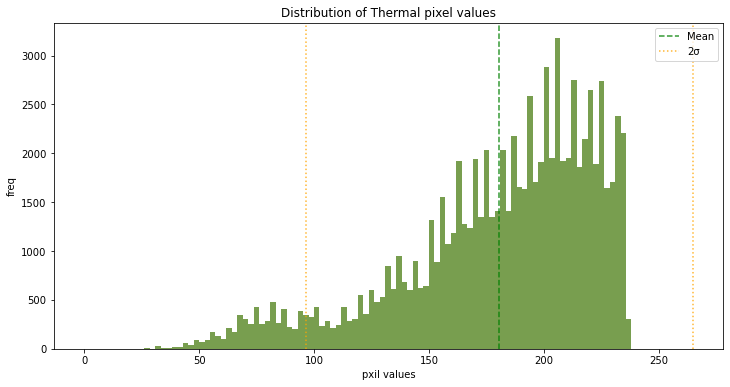

In [12]:
display.display_distributions(all_thermal_data, 
                              filepath = "hist_all_thermal_data.jpg")

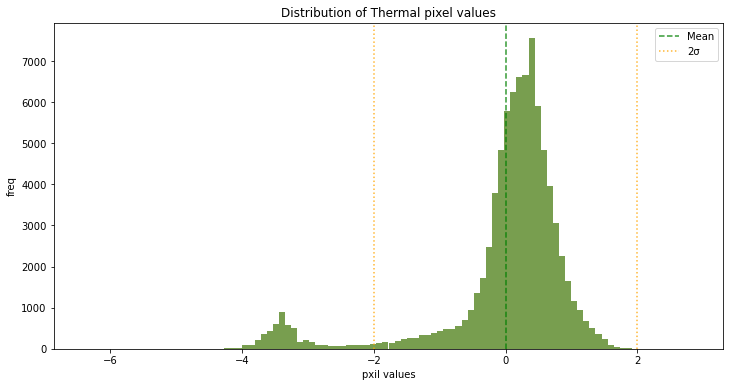

In [13]:
display.display_distributions(scaled_all_thermal_data,
                              filepath = "hist_scaled_all_themal_data.jpg")

In [14]:
mask = (scaled_all_thermal_data > -2).all(axis=1)
masked_scaled_all_thermal_data = scaled_all_thermal_data[mask]

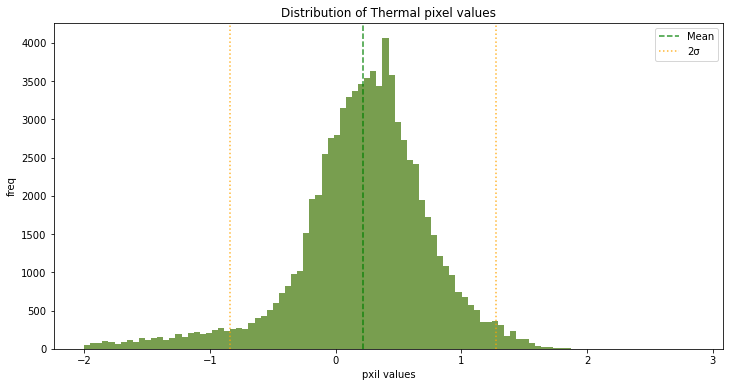

In [15]:
display.display_distributions(masked_scaled_all_thermal_data, 
                              filepath = "hist_masked_scaled_all_themal_data.jpg")

個別画像の分析

In [98]:
#input_file = "72.jpg"
#input_file = "12.jpg"
input_file = "126.jpg"
#input_file = "130.jpg"

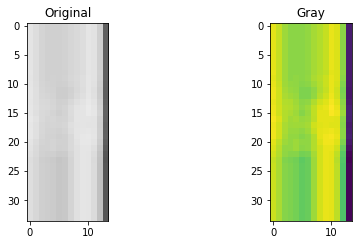

In [99]:
fig = plt.figure(figsize=(16,8),facecolor="w")
ax1 = fig.add_subplot(2,1,1)
ax1.imshow(thermal_img_files[input_file])
ax1.set_title("Original")
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(thermal_img_files_gray[input_file])
ax2.set_title("Gray")
plt.show()

クラスタリング

In [100]:
def get_data_with_index(data):
    data_with_index = []
    for y in range(data.shape[0]):
        for x in range(data.shape[1]):
            idx = y * data.shape[1] + x
            data_with_index.append([*data[y][x], y, x])            
    return np.array(data_with_index)

In [101]:
flatten_thermal_data_with_index = {}
scaled_flatten_thermal_data_with_index = {}
weights = np.array([1, 1, 1, 1, 1])
for k, v in thermal_img_files.items():
    data_with_index = get_data_with_index(v)
    flatten_thermal_data_with_index[k] = data_with_index * weights
    scaled_flatten_thermal_data_with_index[k] = sscaler.fit_transform(data_with_index) * weights

In [102]:
def get_KMeans_results(inputs):
    from sklearn.cluster import KMeans
    model = KMeans(n_clusters=8).fit(inputs)
    return model

In [103]:
#pred = get_KMeans_results(flatten_thermal_data[input_file])
#pred = get_KMeans_results(flatten_thermal_data_with_index[input_file])
pred = get_KMeans_results(scaled_flatten_thermal_data_with_index[input_file])

In [104]:
clusters = []
for n in range(pred.n_clusters):
    data = np.array(
        [ data.tolist() for label, data in zip(pred.labels_, flatten_thermal_data[input_file] ) if label==n ]
    )
    clusters.append(data)

In [105]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

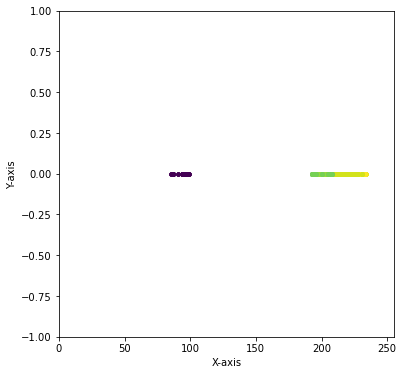

In [106]:
display.plot_2d_scatters_for_clusters(clusters)

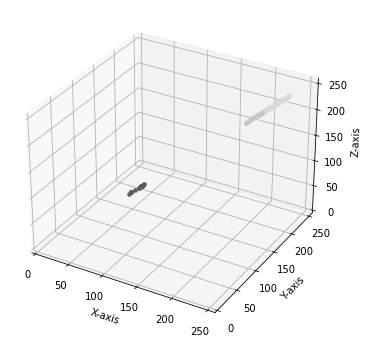

In [107]:
display.plot_3d_scatters_for_clusters(clusters)

In [108]:
centers = np.stack([np.uint8(cluster.mean(axis=0)) for cluster in clusters])

In [109]:
img_clustered = centers[pred.labels_]
img_clustered = img_clustered.reshape(thermal_img_files[input_file].shape)

In [110]:
colors = cm.viridis(pred.labels_)[:, :3]
img_colored = np.uint8(mscaler.fit_transform(colors) * 255)
img_colored = img_colored.reshape(thermal_img_files[input_file].shape)
img_colored  = cv2.cvtColor(img_colored, cv2.COLOR_BGR2GRAY)

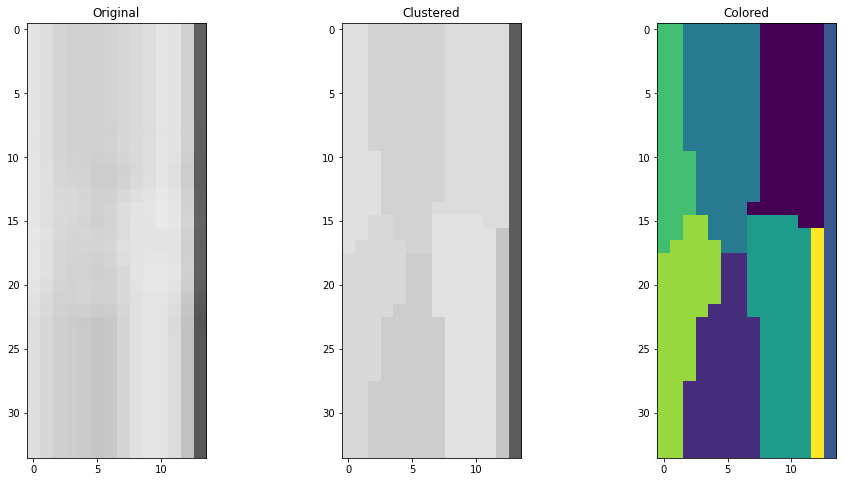

In [111]:
fig = plt.figure(figsize=(16,8),facecolor="w")
ax1 = fig.add_subplot(131)
ax1.imshow(thermal_img_files[input_file])
ax1.set_title("Original")
ax2 = fig.add_subplot(132)
ax2.imshow(img_clustered)
ax2.set_title("Clustered")
ax3 = fig.add_subplot(133)
ax3.imshow(img_colored)
ax3.set_title("Colored")
plt.show()

In [112]:
mask = scaled_flatten_thermal_data[input_file] > -2
mask = mask.reshape(thermal_img_files[input_file].shape)

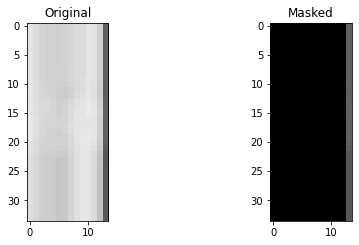

In [113]:
fig = plt.figure(figsize=(16,8),facecolor="w")
ax1 = fig.add_subplot(2,1,1)
ax1.imshow(thermal_img_files[input_file])
ax1.set_title("Original")
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(thermal_img_files[input_file]*~mask)
ax2.set_title("Masked")
plt.show()

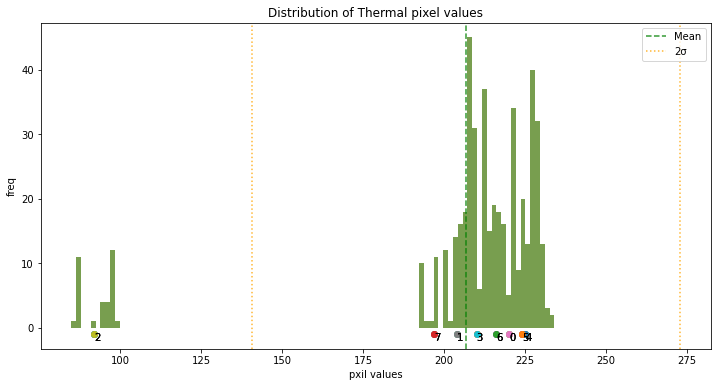

In [114]:
display.display_distributions(flatten_thermal_data[input_file], 
                              filepath = "test.jpg", cluster_centers = centers)

In [115]:
centers

array([[220, 220, 220],
       [204, 204, 204],
       [ 92,  92,  92],
       [210, 210, 210],
       [225, 225, 225],
       [224, 224, 224],
       [216, 216, 216],
       [197, 197, 197]], dtype=uint8)

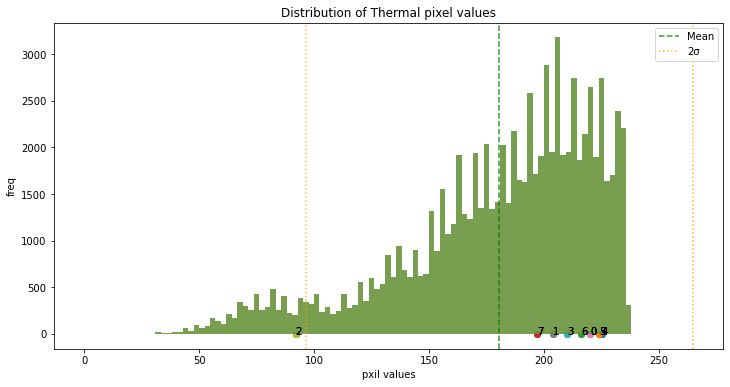

In [116]:
display.display_distributions(all_thermal_data, 
                              filepath = "test.jpg", cluster_centers = centers)

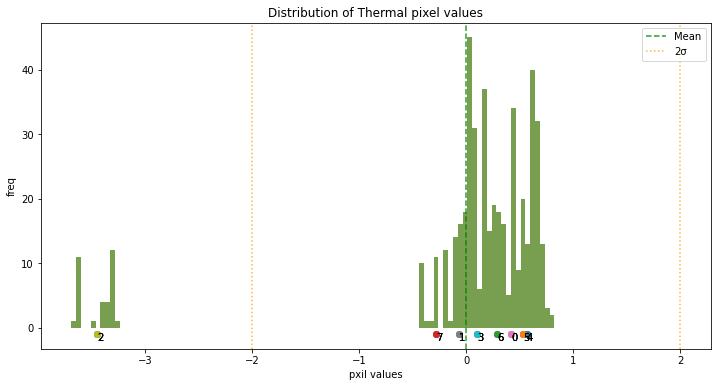

In [117]:
display.display_distributions(scaled_flatten_thermal_data[input_file], 
                              filepath = "test.jpg", cluster_centers = pred.cluster_centers_[:,:3])

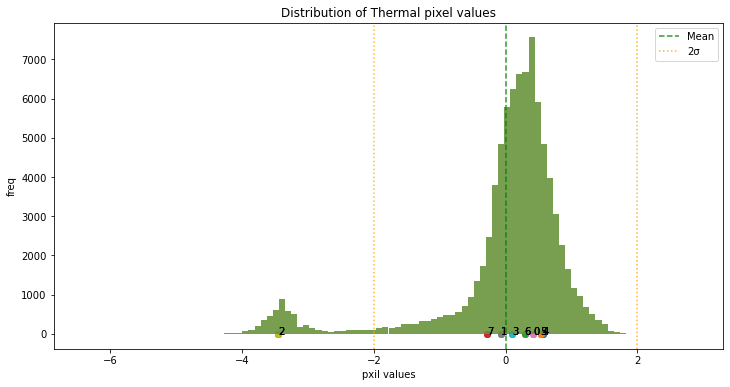

In [118]:
display.display_distributions(scaled_all_thermal_data, 
                              filepath = "test.jpg", cluster_centers = pred.cluster_centers_[:,:3])

In [119]:
mask = (scaled_flatten_thermal_data[input_file] > -2).all(axis=1)

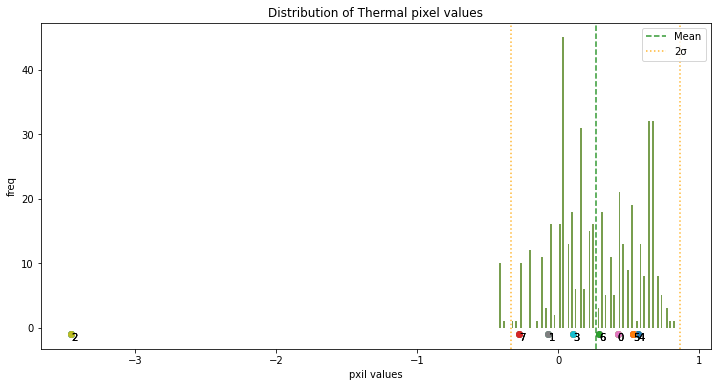

In [120]:
display.display_distributions(scaled_flatten_thermal_data[input_file][mask], 
                              filepath = "test.jpg", cluster_centers = pred.cluster_centers_[:,:3])

In [121]:
mask = (scaled_all_thermal_data > -2).all(axis=1)

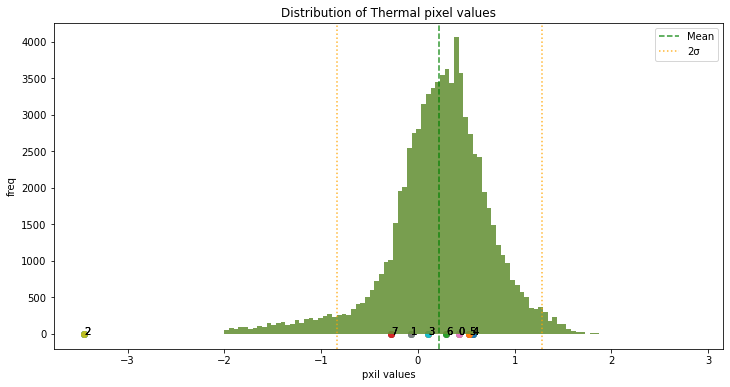

In [122]:
display.display_distributions(scaled_all_thermal_data[mask], 
                              filepath = "test.jpg", cluster_centers = pred.cluster_centers_[:,:3])

In [123]:
from sklearn.mixture import GaussianMixture

In [162]:
gmm = GaussianMixture(
    n_components=4,
    covariance_type='spherical'
).fit(
    scaled_flatten_thermal_data[input_file]
)

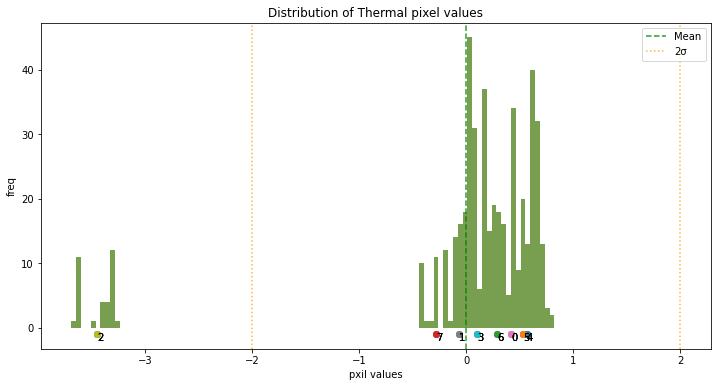

In [163]:
display.display_distributions(scaled_flatten_thermal_data[input_file], 
                              filepath = "test.jpg", cluster_centers = pred.cluster_centers_[:,:3])

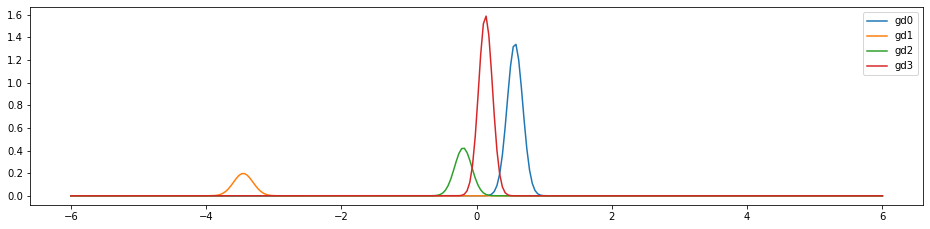

In [164]:
from scipy import stats
fig = plt.figure(figsize=(16,8),facecolor="w")
ax1 = fig.add_subplot(2,1,1)

x = np.linspace(-6, 6, 300)
gd = []
for n in range(gmm.n_components):
    gd.append(stats.norm.pdf(x, gmm.means_[n, -1], np.sqrt(gmm.covariances_[n])))
    plt.plot(x, gmm.weights_[n] * gd[n], label='gd{}'.format(n))
plt.legend()
plt.show()